In [1]:
import pandas as pd

# 데이터 불러오기
b_df = pd.read_csv('./datasets/bank.csv')

# 데이터 복사
pre_b_df = b_df.copy()

# 불필요한 컬럼 삭제하기
pre_b_df = pre_b_df.drop(labels=['id', 'CustomerId'], axis=1).reset_index(drop=True)

# 타겟 데이터 설정하기
pre_b_df['target'] = pre_b_df['Exited']
pre_b_df = pre_b_df.drop(labels=['Exited'], axis=1)

# 타겟 데이터 비중 동일하게 조정 (언더샘플링)
zero = pre_b_df[pre_b_df.target == 0].sample(34921, random_state=124)
one = pre_b_df[pre_b_df.target == 1]

pre_b_df = pd.concat([zero, one])
pre_b_df.reset_index(drop=True, inplace=True)

In [2]:
from sklearn.preprocessing import LabelEncoder

# 문자열 컬럼 추출
columns = ['Surname', 'Geography', 'Gender']
label_encoders = {}

# 컬럼 반복하여 column에 담아 적용:
for column in columns:
    # LabelEncoder 객체 생성, 문자열 데이터 인코딩을 통해 정수로 형변환 후 데이터 교체
    encoder = LabelEncoder()
    # LabelEncoder를 사용하여 각 컬럼의 값을 변환
    result = encoder.fit_transform(pre_b_df[column])
    # 변환된 값의 클래스(고유한 값) 저장
    label_encoders[column] = encoder.classes_
    # 변환된 값 적용
    pre_b_df[column] = result

In [3]:
# 수치형 데이터 이상치 제거
from sklearn.preprocessing import StandardScaler

std_pre_h_df = pre_b_df.copy()
columns = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

for column in columns:
    # 표준화 객체 생성
    std = StandardScaler()
    # 데이터 표준화 변환
    result = std.fit_transform(pre_b_df[[column]])
    # 표준화 데이터 프레임 생성
    std_pre_h_df[column] = result

for column in columns:
    # 타겟 데이터 이상치 제거
    std_pre_h_df = std_pre_h_df[std_pre_h_df[column].between(-1.96, 1.96)]

# 이상치 제거 후 유지되는 인덱스를 대조하여 원본 데이터 이상치 제거
pre_b_df = pre_b_df.iloc[std_pre_h_df.index].reset_index(drop=True)

pre_b_df

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,target
0,2474,584,2,0,34.0,9,123374.11,2,1.0,0.0,158935.83,0
1,1809,592,2,0,44.0,4,0.00,2,1.0,1.0,180696.44,0
2,1426,634,1,0,33.0,9,149349.58,2,0.0,0.0,137517.71,0
3,469,671,1,1,32.0,9,126606.63,2,1.0,0.0,126743.33,0
4,809,763,1,1,35.0,7,124551.66,2,0.0,1.0,47271.61,0
...,...,...,...,...,...,...,...,...,...,...,...,...
60061,413,543,1,0,43.0,9,134542.73,1,1.0,0.0,172363.52,1
60062,1052,576,1,0,26.0,4,114739.92,1,1.0,1.0,27654.64,1
60063,811,767,0,1,38.0,3,0.00,1,1.0,0.0,152872.84,1
60064,940,577,0,0,45.0,2,0.00,1,0.0,0.0,148811.14,1


In [4]:
pre_b3_df = pre_b_df.copy()

In [5]:
from statsmodels.api import OLS

# 데이터 세트 분리
features, targets = pre_b3_df.iloc[:, :-1], pre_b3_df.iloc[:, -1]

# 객체 생성
model = OLS(targets, features)

print(model.fit().summary())

                                 OLS Regression Results                                
Dep. Variable:                 target   R-squared (uncentered):                   0.643
Model:                            OLS   Adj. R-squared (uncentered):              0.643
Method:                 Least Squares   F-statistic:                              9816.
Date:                Wed, 15 May 2024   Prob (F-statistic):                        0.00
Time:                        22:50:22   Log-Likelihood:                         -33113.
No. Observations:               60066   AIC:                                  6.625e+04
Df Residuals:                   60055   BIC:                                  6.635e+04
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

In [6]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def get_vif(features):
    vif = pd.DataFrame()
    vif['vif_score'] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
    vif['features'] = features.columns
    return vif

In [7]:
# 다중 공선성 확인
get_vif(features)

,vif_score,features
0,5.031416,Surname
1,35.617226,CreditScore
2,1.781635,Geography
3,2.060663,Gender
4,20.847383,Age
5,4.028593,Tenure
6,2.126391,Balance
7,7.108805,NumOfProducts
8,3.887614,HasCrCard
9,1.726461,IsActiveMember


In [8]:
# 상관관계 확인
pre_b3_df.corr()['target'].sort_values(ascending=False)[1:]

Age                0.435067
Balance            0.158276
Geography          0.071181
EstimatedSalary    0.022755
Tenure            -0.020973
HasCrCard         -0.023626
CreditScore       -0.035081
Surname           -0.039467
Gender            -0.180396
NumOfProducts     -0.246848
IsActiveMember    -0.259552
Name: target, dtype: float64

<Axes: >

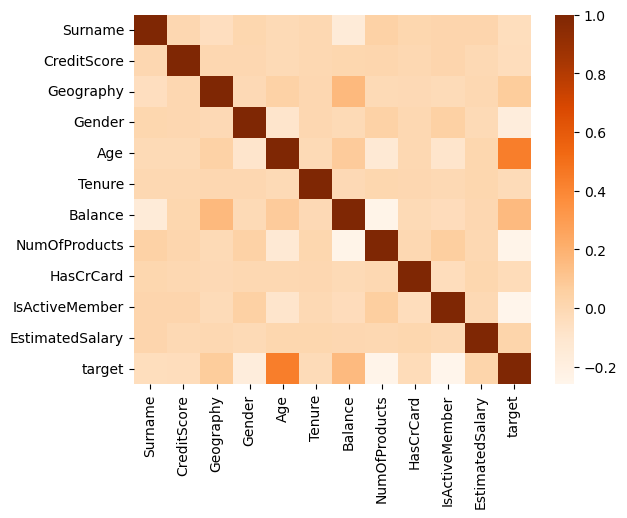

In [9]:
import seaborn as sns

# 히트맵을 통해 상관관계 확인
sns.heatmap(pre_b3_df.corr(), cmap='Oranges')

In [10]:
# 상관 관계가 낮은 피처 제거
pre_b3_df = pre_b3_df.drop(labels=['CreditScore'], axis=1)

In [11]:
from statsmodels.api import OLS

# 데이터 세트 분리
features, targets = pre_b3_df.iloc[:, :-1], pre_b3_df.iloc[:, -1]

# 객체 생성
model = OLS(targets, features)

print(model.fit().summary())

                                 OLS Regression Results                                
Dep. Variable:                 target   R-squared (uncentered):                   0.642
Model:                            OLS   Adj. R-squared (uncentered):              0.642
Method:                 Least Squares   F-statistic:                          1.077e+04
Date:                Wed, 15 May 2024   Prob (F-statistic):                        0.00
Time:                        22:50:25   Log-Likelihood:                         -33169.
No. Observations:               60066   AIC:                                  6.636e+04
Df Residuals:                   60056   BIC:                                  6.645e+04
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

In [12]:
# 다중 공선성 확인
get_vif(features)

,vif_score,features
0,4.778545,Surname
1,1.775402,Geography
2,2.018256,Gender
3,12.943744,Age
4,3.888549,Tenure
5,2.063729,Balance
6,6.216155,NumOfProducts
7,3.757678,HasCrCard
8,1.695410,IsActiveMember
9,6.624715,EstimatedSalary


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

# 데이터 세트 분리
features, targets = pre_b3_df.iloc[:, :-1], pre_b3_df.iloc[:, -1]

X_train, X_test, y_train, y_test = \
train_test_split(features, targets, test_size=0.2, stratify=targets, random_state=124)

# 객체 생성
# penalty: 규제 유형 (l2 = L2 규제)
lg = LogisticRegression(solver='liblinear', penalty='l2', random_state=124)

# 훈련
lg.fit(X_train, y_train)

# 예측
prediction = lg.predict(X_test)

In [15]:
from sklearn.metrics import accuracy_score, precision_score , recall_score , confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_auc_score
import matplotlib.pyplot as plt

def get_evaluation(y_test, prediction, classifier=None, X_test=None):
    confusion = confusion_matrix(y_test, prediction)
    accuracy = accuracy_score(y_test , prediction)
    precision = precision_score(y_test , prediction)
    recall = recall_score(y_test , prediction)
    f1 = f1_score(y_test, prediction)
    roc_auc = roc_auc_score(y_test, prediction)

    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}, AUC:{4:.4f}'.format(accuracy , precision ,recall, f1, roc_auc))
    print("#" * 75)
    
    if classifier is not None and  X_test is not None:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
        titles_options = [("Confusion matrix", None), ("Normalized confusion matrix", "true")]

        for (title, normalize), ax in zip(titles_options, axes.flatten()):
            disp = ConfusionMatrixDisplay.from_estimator(classifier, X_test, y_test, ax=ax, cmap=plt.cm.Blues, normalize=normalize)
            disp.ax_.set_title(title)
        plt.show()

오차 행렬
[[3481 2605]
 [1778 4150]]
정확도: 0.6352, 정밀도: 0.6144, 재현율: 0.7001, F1:0.6544, AUC:0.6360
###########################################################################


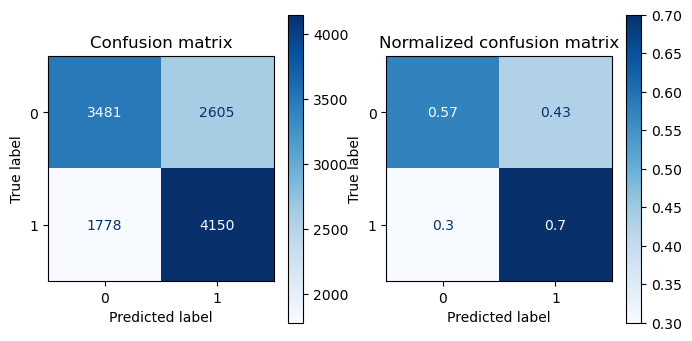

In [16]:
get_evaluation(y_test, prediction, lg, X_test)

In [17]:
# 상관 관계가 낮은 피처 제거
pre_b3_2_df = pre_b3_df.drop(labels=['IsActiveMember', 'NumOfProducts', 'Gender'], axis=1)

In [18]:
from statsmodels.api import OLS

# 데이터 세트 분리
features, targets = pre_b3_2_df.iloc[:, :-1], pre_b3_2_df.iloc[:, -1]

# 객체 생성
model = OLS(targets, features)
print(model.fit().summary())

                                 OLS Regression Results                                
Dep. Variable:                 target   R-squared (uncentered):                   0.581
Model:                            OLS   Adj. R-squared (uncentered):              0.581
Method:                 Least Squares   F-statistic:                          1.190e+04
Date:                Wed, 15 May 2024   Prob (F-statistic):                        0.00
Time:                        22:50:45   Log-Likelihood:                         -37886.
No. Observations:               60066   AIC:                                  7.579e+04
Df Residuals:                   60059   BIC:                                  7.585e+04
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

In [19]:
# 다중 공선성 확인
get_vif(features)

,vif_score,features
0,4.617203,Surname
1,1.767453,Geography
2,11.520437,Age
3,3.803565,Tenure
4,2.010556,Balance
5,3.698680,HasCrCard
6,6.389853,EstimatedSalary


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

# 데이터 세트 분리
features, targets = pre_b3_2_df.iloc[:, :-1], pre_b3_2_df.iloc[:, -1]

X_train, X_test, y_train, y_test = \
train_test_split(features, targets, test_size=0.2, stratify=targets, random_state=124)

# 객체 생성
# penalty: 규제 유형 (l2 = L2 규제)
lg = LogisticRegression(solver='liblinear', penalty='l2', random_state=124)

# 훈련
lg.fit(X_train, y_train)

# 예측
prediction = lg.predict(X_test)

오차 행렬
[[3346 2740]
 [1850 4078]]
정확도: 0.6179, 정밀도: 0.5981, 재현율: 0.6879, F1:0.6399, AUC:0.6189
###########################################################################


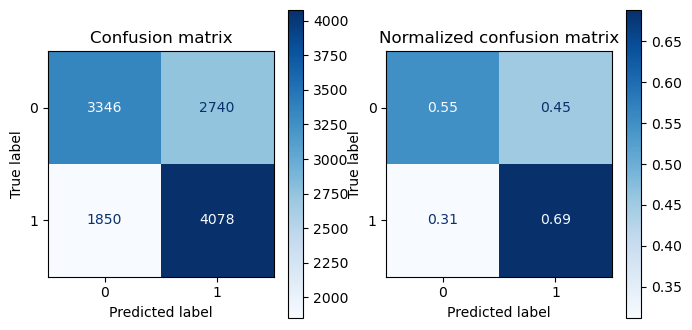

In [21]:
get_evaluation(y_test, prediction, lg, X_test)